In [2]:
## Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN

from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# For upsampling during the modeling
from imblearn.over_sampling import SMOTE
from geopy.distance import geodesic
import re
import geopandas as gpd
import glob
from kneed import KneeLocator
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
import hdbscan
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform, truncnorm, randint
from sklearn.preprocessing import scale
from KmeansWithNulls import KmeansWithNulls

Preprocessing (loading data and scaling)

In [3]:
# Get preprocessed train and test data
feats = pd.read_csv("xgboost_preprocessed_data/xgboost_data_new100.csv")

In [4]:
## Fill NA values with mean 
cols_to_imp = ['speed_std', 'dist_std', 'x_std', 'y_std']
feats[cols_to_imp] = feats[cols_to_imp].fillna(feats[cols_to_imp].mean())


In [5]:
## Scale features that still need to be scaled

scaled_colum = ['speed_0',
       'speed_med', 'speed_99', 'speed_std', 'dist_med', 'dist_99', 'dist_std','entries']
scaler = StandardScaler()
scaled_feats = feats.copy()
for i in scaled_colum:
    scaled_feats[i] = scale(scaled_feats[i])
    

In [6]:
scaled_feats = pd.DataFrame(scaled_feats, columns = feats.columns)

In [7]:
## Select final features to model with
clust_feats = scaled_feats[['speed_0',
       'speed_med', 'speed_99', 'speed_std', 'dist_med', 'dist_99', 'dist_std',
       'x_0', 'x_med', 'x_99', 'x_std', 'y_0', 'y_med', 'y_99', 'y_std', 'entries']]
clust_feats.head()

,speed_0,speed_med,speed_99,speed_std,dist_med,dist_99,dist_std,x_0,x_med,x_99,x_std,y_0,y_med,y_99,y_std,entries
0,-0.264238,-0.380418,-0.608081,-0.797178,-0.058250,-0.063238,-0.076438,0.133253,0.133253,0.133253,0.000000,0.651053,0.651053,0.651053,0.000000,-0.342891
1,0.239545,0.429431,0.378932,1.276807,0.269897,0.283699,0.729559,0.037781,0.059676,0.081572,0.030965,0.699434,0.835477,0.971519,0.192393,-0.359015
2,-0.264238,-0.380418,-0.608081,-0.797178,-0.058250,-0.063238,-0.076438,0.069601,0.069601,0.069601,0.000000,0.200804,0.200804,0.200804,0.000000,-0.348266
3,-0.264238,-0.380418,-0.608081,-0.797178,1.025515,0.509685,1.010310,0.069601,0.133253,0.133253,0.036749,0.200814,0.651043,0.651053,0.259943,-0.353641
4,-0.264238,0.417694,0.183586,0.774633,0.620295,5.058441,7.032474,0.069601,0.397178,0.401358,0.091522,0.200814,0.918348,0.969039,0.239350,-0.208527


## Doing kmeans

### elbo to find number of clusters

In [8]:
kmeans_kwargs = {
     "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
 }
# A list holds the SSE values for each k
sse = []
for k in range(1, 10):
     kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
     kmeans.fit(clust_feats)
     sse.append(kmeans.inertia_)

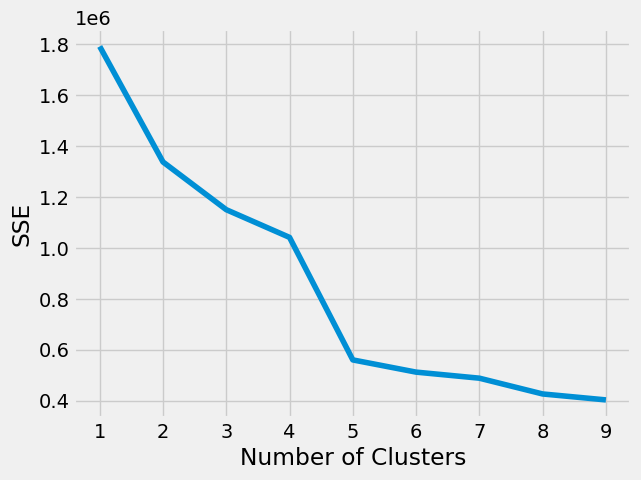

In [9]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 10), sse)
plt.xticks(range(1, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [10]:
## Identifying number of clusters
kl = KneeLocator(range(1, 10), sse, curve="convex", direction="decreasing")
kl.elbow


5

In [11]:
kmeans = KMeans(n_clusters=kl.elbow)
kmeans.fit(clust_feats)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print("Centroids:")
print(centroids)
print("Labels:")
print(labels)

/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Centroids:
[[-7.61125268e-02 -1.54782948e-01 -3.18885940e-01 -3.98644878e-01
  -4.34647418e-02 -4.93624759e-02 -4.31680821e-02  2.43687919e-01
   2.47178760e-01  2.50366284e-01  4.21859396e-03  6.23608373e-01
   6.26617338e-01  6.29572997e-01  3.79511099e-03 -2.70871449e-01]
 [ 8.36866247e+00  8.12285057e+00  6.85453473e+00  2.27781805e-02
  -5.66050497e-02 -6.03030413e-02 -9.16243637e-03  2.36743832e-01
   2.37539704e-01  2.37826240e-01  7.15407305e-03  5.66251215e-01
   5.67506205e-01  5.68043993e-01  6.96537713e-03 -3.38419625e-01]
 [-2.64238010e-01 -3.74549159e-01  8.75865345e-01  1.03627485e+00
   2.33140087e+02  2.30591074e+02  2.31052073e+02  5.55344440e-02
   1.72526784e-01  5.05596779e-01  9.12062062e-02  3.16162990e-01
   6.05923785e-01  9.53375734e-01  1.49738828e-01  8.06653033e+00]
 [-2.29090200e-01 -1.85922360e-01  4.58013336e-01  4.96530780e-01
   3.27913373e-01  4.07410548e-01  3.69552682e-01  1.69424830e-01
   2.20283938e-01  2.76332738e-01  3.07580604e-02  5.35991969e

In [12]:
clusters = kmeans.fit_predict(clust_feats)

# dict to store clusters data
cluster_dict=[]
for c in clusters:
    cluster_dict.append(c)

# prints the cluster dict
#cluster_dict

# adds the cluster information as a column in the df
feats['cluster'] = cluster_dict

# saves the df as a csv
feats.to_csv('kmeans_results_scaled.csv', index=False)

# shows the resulting df
#print(feats)

# shows each separate cluster
#for c in clusters:
    #print(feats[feats['cluster'] == c].head(10))

/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Doing HBDSCAN 

Notes: parameters of hdbscan are supposed to be intuitive, consider plotting beforehand for EDA
min_samples= if specified and larger, more will be declared as noise
cluster_selection_epsilon = attempts to break up micro clusters, use if you want to recognize small clusters but also have clusters that are dense

Same pre-processing here

In [6]:
## Same preparation with preprocessed data
feats = pd.read_csv("xgboost_preprocessed_data/xgboost_data_new100.csv")

In [7]:
cols_to_imp = ['speed_std', 'dist_std', 'x_std', 'y_std']
feats[cols_to_imp] = feats[cols_to_imp].fillna(feats[cols_to_imp].mean())
feats.columns

Index(['mmsi', 'occ_num', 'net_name', 'mmsi_length', 'spawn_offshore', 'spoof',
       'speed_0', 'speed_med', 'speed_99', 'speed_std', 'dist_med', 'dist_99',
       'dist_std', 'x_0', 'x_med', 'x_99', 'x_std', 'y_0', 'y_med', 'y_99',
       'y_std', 'red_flags', 'entries'],
      dtype='object')

In [8]:
scaled_colum = ['speed_0',
       'speed_med', 'speed_99', 'speed_std', 'dist_med', 'dist_99', 'dist_std']
scaler = StandardScaler()
scaled_feats = feats.copy()
for i in scaled_colum:
    scaled_feats[i] = scale(scaled_feats[i])

   

In [9]:
scaled_feats = pd.DataFrame(scaled_feats, columns = feats.columns)
clust_feats = scaled_feats[['speed_0',
       'speed_med', 'speed_99', 'speed_std', 'dist_med', 'dist_99', 'dist_std',
       'x_0', 'x_med', 'x_99', 'x_std', 'y_0', 'y_med', 'y_99', 'y_std']]
clust_feats.head()

,speed_0,speed_med,speed_99,speed_std,dist_med,dist_99,dist_std,x_0,x_med,x_99,x_std,y_0,y_med,y_99,y_std
0,-0.264238,-0.380418,-0.608081,-0.797178,-0.058250,-0.063238,-0.076438,0.133253,0.133253,0.133253,0.000000,0.651053,0.651053,0.651053,0.000000
1,0.239545,0.429431,0.378932,1.276807,0.269897,0.283699,0.729559,0.037781,0.059676,0.081572,0.030965,0.699434,0.835477,0.971519,0.192393
2,-0.264238,-0.380418,-0.608081,-0.797178,-0.058250,-0.063238,-0.076438,0.069601,0.069601,0.069601,0.000000,0.200804,0.200804,0.200804,0.000000
3,-0.264238,-0.380418,-0.608081,-0.797178,1.025515,0.509685,1.010310,0.069601,0.133253,0.133253,0.036749,0.200814,0.651043,0.651053,0.259943
4,-0.264238,0.417694,0.183586,0.774633,0.620295,5.058441,7.032474,0.069601,0.397178,0.401358,0.091522,0.200814,0.918348,0.969039,0.239350


In [10]:
## Run HDBSCAN for original iteration with min cluster size of 5 and epsilon of 0.5
clusterer = hdbscan.HDBSCAN(min_cluster_size = 5, cluster_selection_epsilon = 0.5).fit_predict(clust_feats)

In [11]:
#Appending resulting clusters to original pre-processed data and saving as new csv

cluster_dict=[]
for c in clusterer:
    cluster_dict.append(c)

# prints the cluster dict
#cluster_dict

# adds the cluster information as a column in the df
feats['cluster'] = cluster_dict

feats.to_csv('hdb_results_5new.csv', index=False)

Showing some quick stats on the cluster break down (number of clusters and )

In [14]:
max(feats.cluster)

39